In [1]:
%load_ext autoreload
%autoreload 2

In [62]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import sys
import matplotlib.patches as mpatches

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [148]:
from datasets.nuscenes import *
from datasets.carla import *
from tools.utils import *
from tools.loss import *
from tools.geometry import *
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm.notebook import trange

from numpy.linalg import inv

In [64]:
carla_data = CarlaDataset("../../data/carla/train", False)

In [153]:
evidential = Evidential([7], backbone="lss")
evidential.load(torch.load("../outputs/carla/lss_evidential_focal/19.pt"))

Loaded pretrained weights for efficientnet-b0


In [201]:
images, intrinsics, extrinsics, labels, ood = carla_data[64]

In [202]:
alpha = evidential(images[None].to(7), intrinsics[None].to(7), extrinsics[None].to(7)).detach().cpu()
aleatoric = evidential.aleatoric(alpha)[0, 0].numpy()
preds = evidential.activate(alpha)      

pmax = preds.argmax(1)
lmax = labels.argmax(0)

In [203]:
ac = plt.cm.jet(aleatoric)

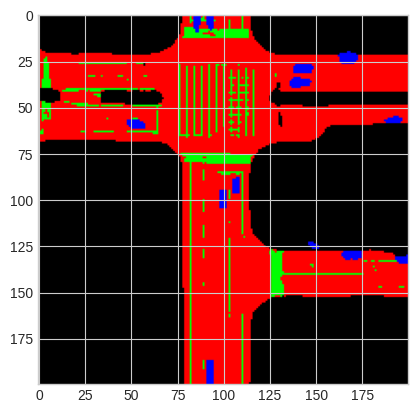

In [204]:
label = map_rgb(labels) / 255
pred = map_rgb(preds[0]) / 255

plt.imshow(pred)

In [205]:
cam_index = 2

intrinsic = intrinsics[cam_index]
extrinsic = inv(extrinsics[cam_index])
adjust_carla(extrinsic)

In [206]:
coords = []
color = []
alpha = []

for i in range(200):
    for j in range(200):
        coords.append([i/2 - 50, j/2 - 50, 0])

        if labels[3, i, j] == 1:
            alpha.append(0)
        else:
            alpha.append(.1)

        color.append(ac[i, j])        

alpha = np.array(alpha)
coords = np.array(coords) 
color = np.array(color)

In [207]:
points, mask = get_image_points(coords, intrinsic, extrinsic)
points = points[mask]

(-0.5, 503.9817206811675, 235.12774975005124, -0.5)

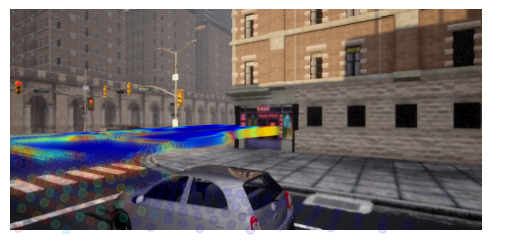

In [208]:
plt.imshow(images[cam_index].permute(1, 2, 0).numpy())
plt.scatter(points[:, 0], points[:, 1], color=color[mask], alpha=alpha[mask])
plt.axis("off")

(-0.5, 199.5, 199.5, -0.5)

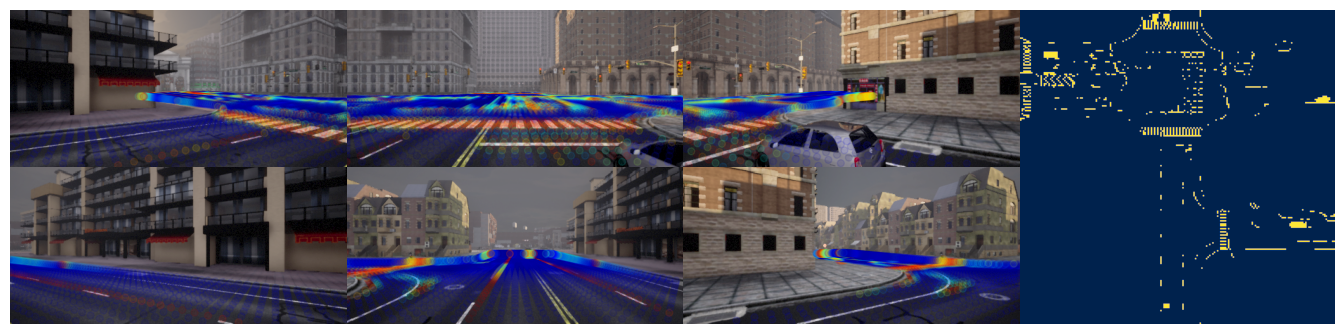

In [209]:
rat = 224/480
val = 10.1
fig = plt.figure(figsize=(val + val / 3 * rat * 2 , val/3*2*rat))
gs = mpl.gridspec.GridSpec(2, 4, width_ratios=(1, 1, 1, 2*rat))
gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)
                     
for i in range(6):
    ax = plt.subplot(gs[i // 3, i % 3])
    
    image = images[i].cpu().permute(1, 2, 0)
    ax.imshow(image)               

    intrinsic = intrinsics[i]
    extrinsic = inv(extrinsics[i])
    adjust_carla(extrinsic)
    
    points, mask = get_image_points(coords, intrinsic, extrinsic)
    
    points = points[mask]
    ax.scatter(points[:, 0], points[:, 1], alpha=alpha[mask], s=100, color=color[mask], marker='.')
    ax.axis("off")
    ax.set_xlim([0, image.shape[1]])
    ax.set_ylim([image.shape[0], 0])

ax = plt.subplot(gs[:, 3:4])
ax.imshow((pmax != lmax)[0], cmap='cividis')
ax.axis("off")

In [212]:

save = 'uncmap_frames'
os.makedirs(save, exist_ok=True)

for k in trange(50):
    images, intrinsics, extrinsics, labels, ood = carla_data[k]
    
    alpha = evidential(images[None].to(7), intrinsics[None].to(7), extrinsics[None].to(7)).detach().cpu()
    aleatoric = evidential.aleatoric(alpha)[0, 0].numpy()
    preds = evidential.activate(alpha)      
    ac = plt.cm.jet(aleatoric)
    
    pmax = preds.argmax(1)
    lmax = labels.argmax(0)
    
    coords = []
    color = []
    alpha = []
    
    for i in range(200):
        for j in range(200):
            coords.append([i/2 - 50, j/2 - 50, 0])
    
            if labels[3, i, j] == 1:
                alpha.append(0)
            else:
                alpha.append(.1)
    
            color.append(ac[i, j])        
    
    alpha = np.array(alpha)
    coords = np.array(coords) 
    color = np.array(color)
        
    rat = 224/480
    val = 10.1
    fig = plt.figure(figsize=(val + val / 3 * rat * 2 , val/3*2*rat))
    gs = mpl.gridspec.GridSpec(2, 4, width_ratios=(1, 1, 1, 2*rat))
    gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)
                         
    for i in range(6):
        ax = plt.subplot(gs[i // 3, i % 3])
        
        image = images[i].cpu().permute(1, 2, 0)
        ax.imshow(image)               
    
        intrinsic = intrinsics[i]
        extrinsic = inv(extrinsics[i])
        adjust_carla(extrinsic)
        
        points, mask = get_image_points(coords, intrinsic, extrinsic)
        
        points = points[mask]
        ax.scatter(points[:, 0], points[:, 1], alpha=alpha[mask], s=100, color=color[mask], marker='.')
        ax.axis("off")
        ax.set_xlim([0, image.shape[1]])
        ax.set_ylim([image.shape[0], 0])
    
    ax = plt.subplot(gs[:, 3:4])
    ax.imshow((pmax != lmax)[0], cmap='cividis')
    ax.axis("off")
    
    fig.savefig(f"{save}/{k}.png", bbox_inches="tight")
    plt.close()

  0%|          | 0/50 [00:00<?, ?it/s]